In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os
from tensorflow.keras.datasets.mnist import load_data
from time import time

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
IS_NEW_RUN = False
mb_size = 64
z_dim = 100
lr = 2e-4
beta = (0.5, 0.999)

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data()
x_train = np.vstack([x_train, x_test])

X_train = torch.tensor(x_train, dtype=torch.float32, device=device)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]))
# minmax scaling
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())

In [ ]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
        )
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, y=None):
        f = self.conv(x)
        f = f.view(f.size(0), -1)
        f = self.fc(f)
        return f

In [ ]:
class Generator(nn.Module): 
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 4*4*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            # input: 4 by 4, output: 7 by 7
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1, bias=False),
            nn.Sigmoid(),
            # nn.Tanh(),
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        f = self.fc(x)
        f = f.view(f.size(0), 512, 4, 4)
        f = self.conv(f)
        return f

In [ ]:
def mb_sample(X, mb_size):
    idx = np.random.randint(len(X), size=mb_size)
    return X[idx]


def reset_grad():
    G.zero_grad()
    D.zero_grad()


def backup(current_epoch, score, training_time, D, G, D_solver, G_solver):
    T = time()
    torch.save({
            'epoch': current_epoch,
            'discriminator_state_dict': D.state_dict(),
            'generator_state_dict': G.state_dict(),
            'D_solver_state_dict': D_solver.state_dict(),
            'G_solver_state_dict': G_solver.state_dict(),
            'score': score,
            'time': training_time
            }, 'drive/My Drive/Colab Notebooks/GANs/GAN_model.tar')
    print(f'backup done in {round(time()-T, 2)}s')

In [ ]:
D = Discriminator().to(device)
G = Generator().to(device)

loss = nn.BCELoss()
G_solver = optim.Adam(G.parameters(), lr=lr, betas=beta)
D_solver = optim.Adam(D.parameters(), lr=lr, betas=beta)

epoch=0
prev_time = 0
score = []

if not IS_NEW_RUN:
    checkpoint = torch.load('drive/My Drive/Colab Notebooks/GANs/GAN_model.tar', map_location=device)
    D.load_state_dict(checkpoint['discriminator_state_dict'])
    G.load_state_dict(checkpoint['generator_state_dict'])
    D.train()
    G.train()
    D_solver.load_state_dict(checkpoint['D_solver_state_dict'])
    G_solver.load_state_dict(checkpoint['G_solver_state_dict'])

    epoch = checkpoint['epoch']
    score = checkpoint['score']
    prev_time = checkpoint['time']


print('Current epoch is', epoch)
print('Time spent for training {}m'.format(round(prev_time, 1)))

Current epoch is 500000
Time spent for training 425.2m


backup done in 0.22s
Iter-500000; D_loss: 0.00202; G_loss: 6.04628; time spent 0.0m


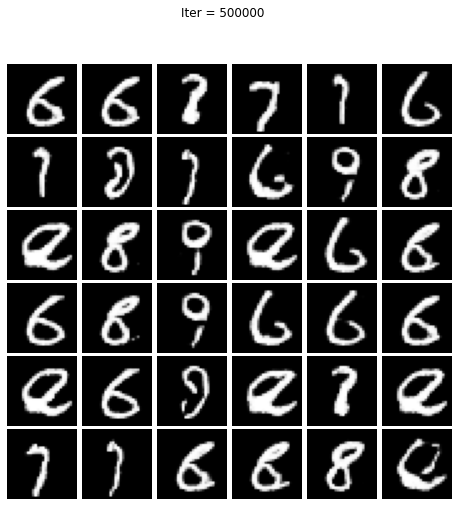

backup done in 0.21s
Iter-505000; D_loss: 0.01647; G_loss: 6.36139; time spent 3.2m


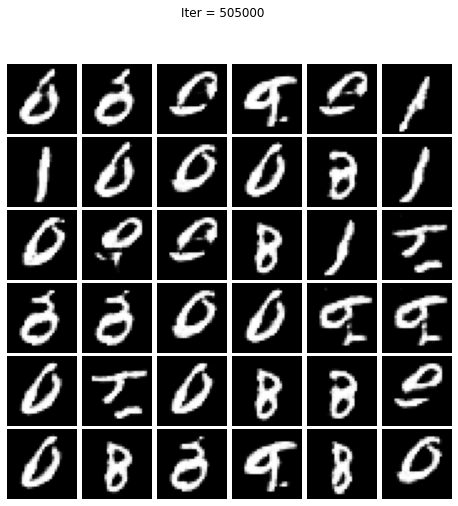

backup done in 0.22s
Iter-510000; D_loss: 0.00329; G_loss: 10.54833; time spent 6.4m


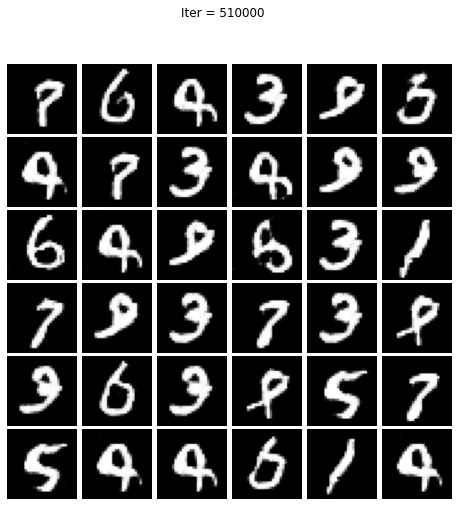

backup done in 0.21s
Iter-515000; D_loss: 0.00945; G_loss: 7.03477; time spent 9.6m


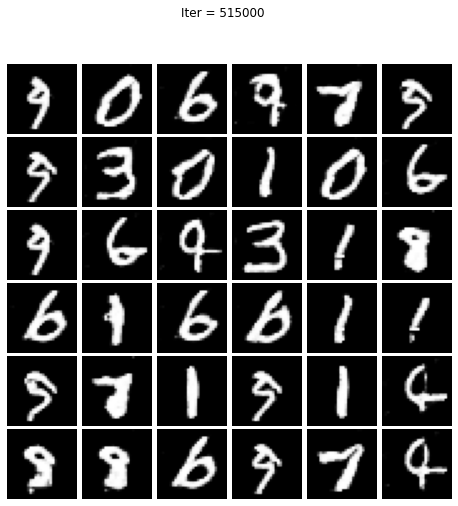

backup done in 0.21s
Iter-520000; D_loss: 0.00563; G_loss: 6.98182; time spent 12.8m


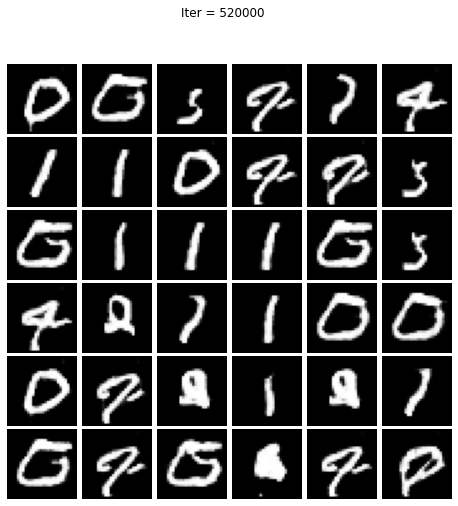

backup done in 0.21s
Iter-525000; D_loss: 0.0043; G_loss: 6.9124; time spent 16.0m


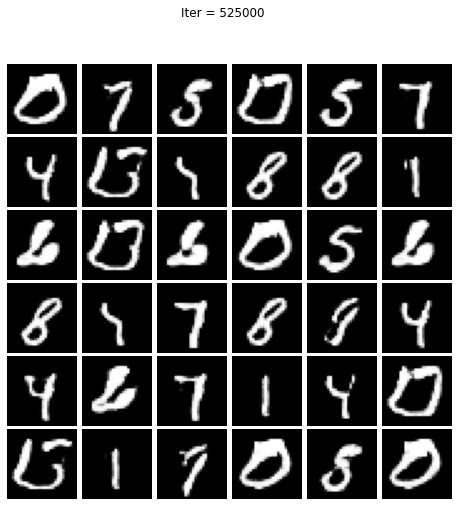

backup done in 0.2s
Iter-530000; D_loss: 0.00179; G_loss: 8.41799; time spent 19.1m


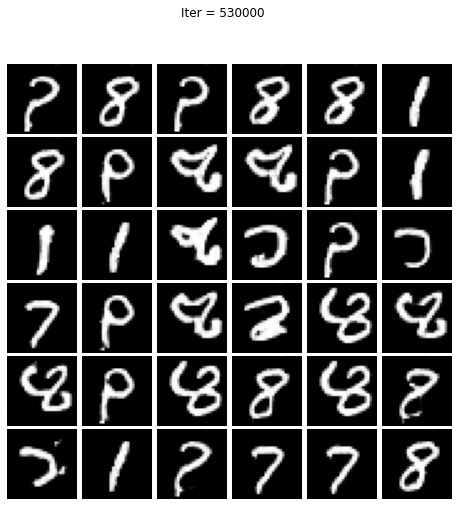

backup done in 0.2s
Iter-535000; D_loss: 0.00318; G_loss: 8.68445; time spent 22.3m


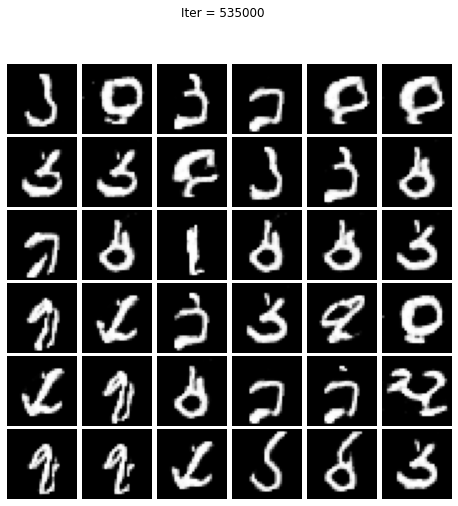

backup done in 0.22s
Iter-540000; D_loss: 0.00155; G_loss: 7.34484; time spent 25.5m


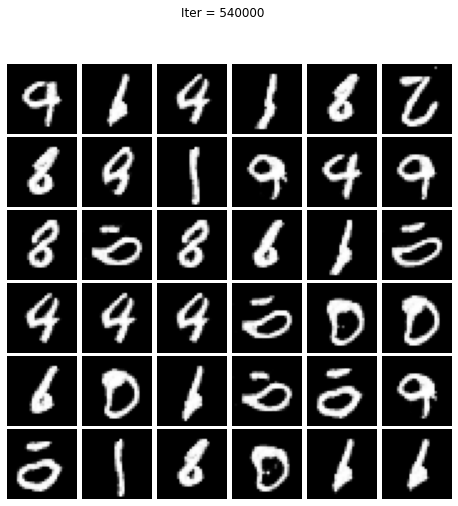

backup done in 0.21s
Iter-545000; D_loss: 0.00073; G_loss: 8.00531; time spent 28.7m


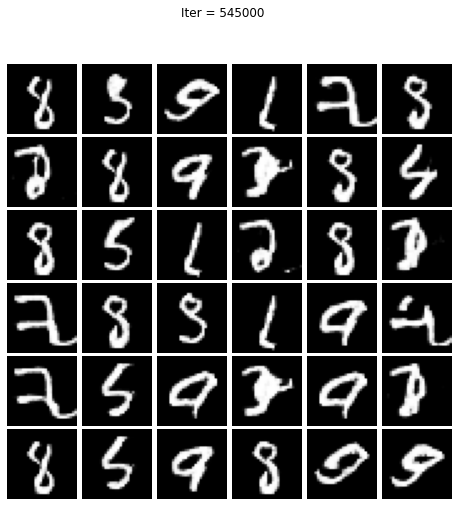

backup done in 0.2s
Iter-550000; D_loss: 0.00268; G_loss: 8.63961; time spent 31.9m


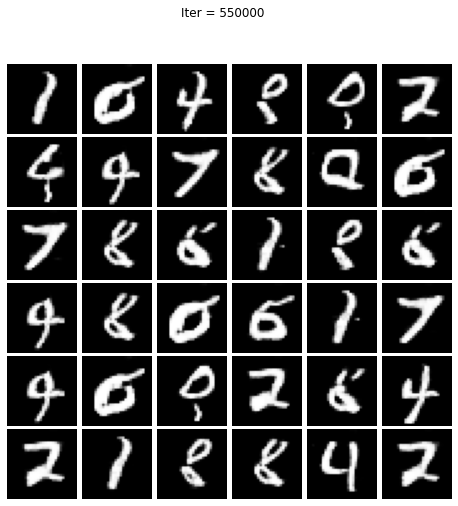

backup done in 0.2s
Iter-555000; D_loss: 0.00098; G_loss: 6.4446; time spent 35.1m


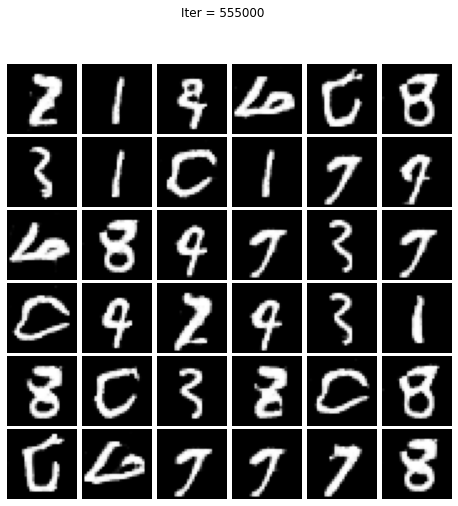

backup done in 0.21s
Iter-560000; D_loss: 0.00219; G_loss: 8.01151; time spent 38.3m


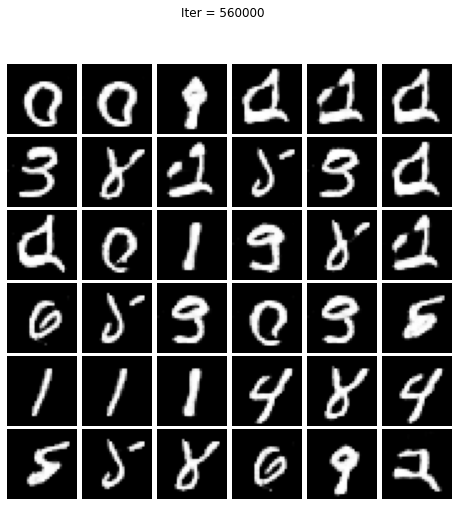

backup done in 0.22s
Iter-565000; D_loss: 0.0105; G_loss: 5.49627; time spent 41.5m


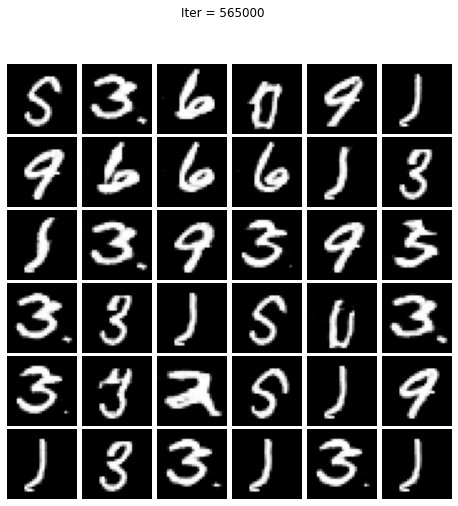

backup done in 0.21s
Iter-570000; D_loss: 0.00045; G_loss: 6.97272; time spent 44.7m


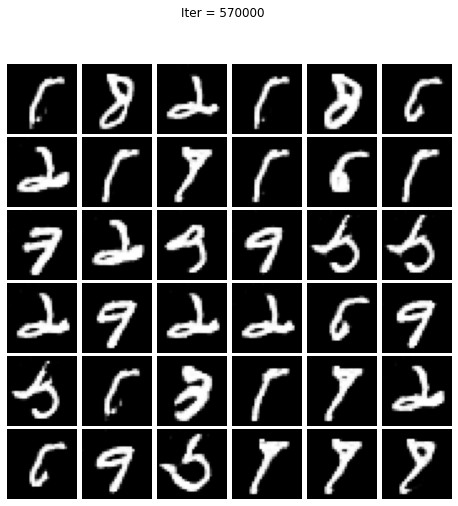

backup done in 0.21s
Iter-575000; D_loss: 0.00059; G_loss: 8.45803; time spent 47.9m


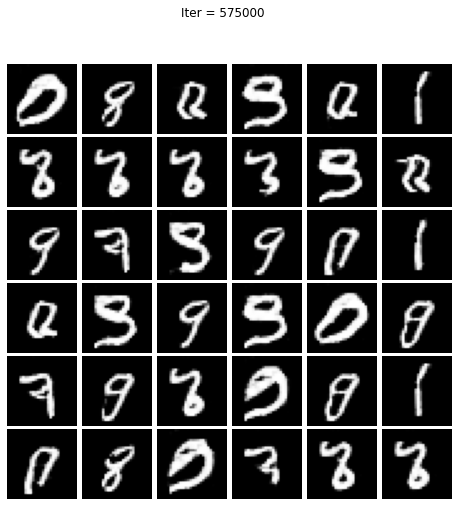

backup done in 0.2s
Iter-580000; D_loss: 0.00502; G_loss: 7.20907; time spent 51.0m


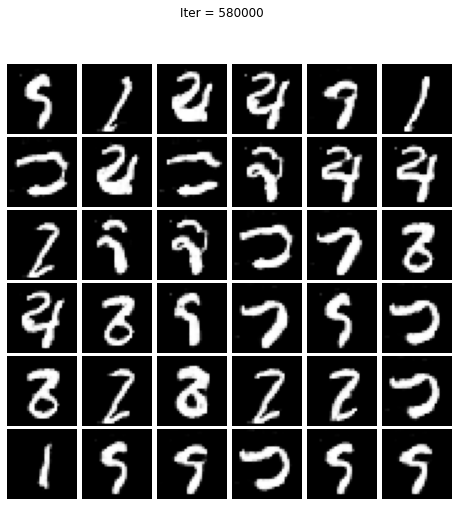

backup done in 0.2s
Iter-585000; D_loss: 0.00203; G_loss: 8.72833; time spent 54.2m


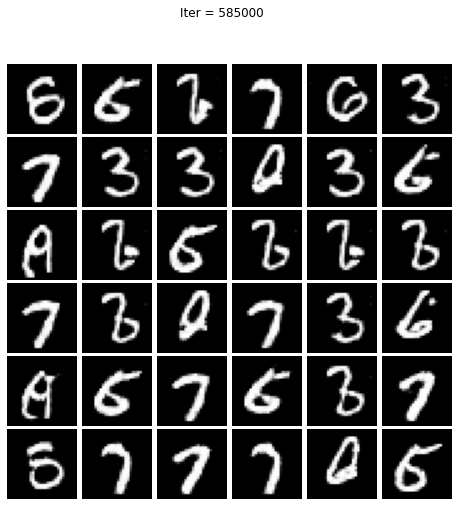

backup done in 0.21s
Iter-590000; D_loss: 0.00179; G_loss: 7.7488; time spent 57.4m


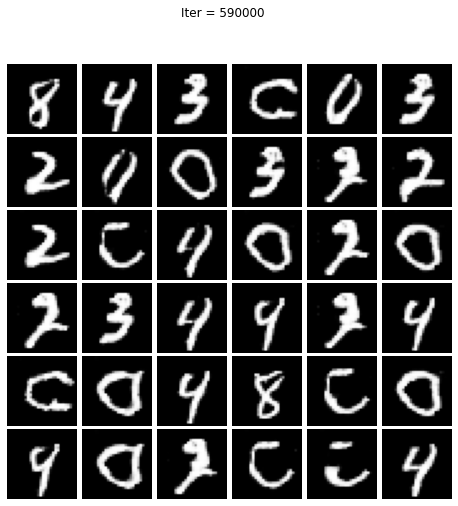

backup done in 0.2s
Iter-595000; D_loss: 0.00359; G_loss: 6.17447; time spent 60.6m


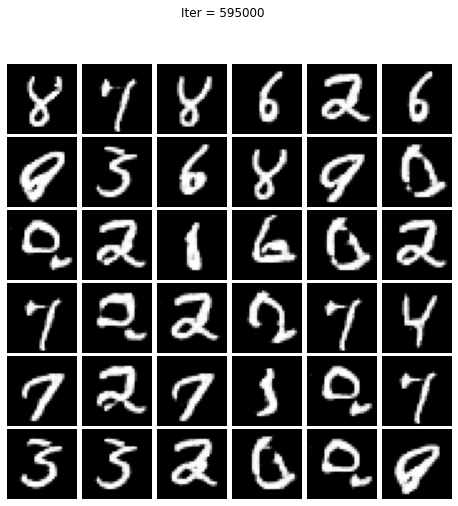

backup done in 0.21s
Iter-600000; D_loss: 0.01261; G_loss: 5.65304; time spent 63.8m


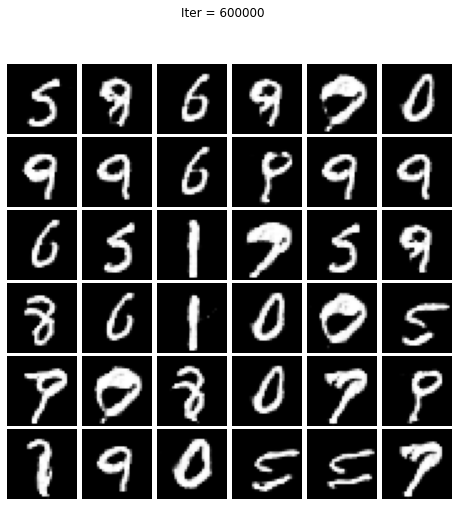

In [ ]:
ones_label = torch.ones(mb_size, 1).to(device)
zeros_label = torch.zeros(mb_size, 1).to(device)


t = time()
for it in range(100001):
    # Sample data
    z = torch.rand(mb_size, z_dim, device=device)
    X = mb_sample(X_train, mb_size)

    # Dicriminator
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)

    D_loss = loss(D_real, ones_label) + loss(D_fake, zeros_label)
    D_loss.backward()
    D_solver.step()
    reset_grad()

    # Generator
    z = torch.rand(mb_size, z_dim, device=device)
    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = loss(D_fake, ones_label)
    G_loss.backward()
    G_solver.step()
    reset_grad()
    
    current_epoch = epoch + it

    # Print and plot every now and then
    plot_interval = 5000
    if it % plot_interval == 0:
        score.append([D_loss.item(), G_loss.item(), current_epoch])
      
        training_time = prev_time + (time()-t)/60
        backup(current_epoch, score, training_time, D, G, D_solver, G_solver)

        print('Iter-{}; D_loss: {}; G_loss: {}; time spent {}m'
              .format(current_epoch, round(D_loss.item(), 5), round(G_loss.item(),5), round((time()-t)/60, 1)))

        samples = G(z).to("cpu", torch.double).data.numpy()[:36]

        fig = plt.figure(figsize=(8, 8))
        gs = gridspec.GridSpec(6, 6)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        plt.suptitle(f'Iter = {current_epoch}')
        plt.savefig(f'drive/My Drive/Colab Notebooks/GANs/simple_GAN_figs/{current_epoch}.png')
        plt.show()
        plt.close()
epoch = current_epoch